## Running the Fast & Fusiest Mapper (FFM)
This notebook shows how to run the Fast & Fusiest Mapper (FFM) on a full workload and
architecture.

We first initialize the spec. The spec is initialized with a `ff.Spec` object
using YAML files (though you may also initialize them with Python objects).

When loading specifications, Jinja2 templating can be used, and the `jinja_parse_data`
parameter can be used to pass in data to the templating engine.

In [1]:
from pathlib import Path

examples_dir = Path("../../examples")

# < DOC_INCLUDE_MARKER > make_spec
import fastfusion as ff

# Set the number of parallel threads that the mapper can use. If you are running out of
# memory, you may decrease this number. By default the number of threads is set to the
# number of cores on your machine.
import os
ff.set_n_parallel_jobs(os.cpu_count(), print_message=True)

# Initialize the spec and show the workload.
BATCH_SIZE = 1
N_TOKENS = 16384
FUSE = False

spec = ff.Spec.from_yaml(
    examples_dir / "arches" / "tpu_v4i_like.arch.yaml",
    examples_dir / "workloads" / "gpt3_6.7B.workload.yaml",
    jinja_parse_data=dict(
        BATCH_SIZE=BATCH_SIZE,
        N_TOKENS=N_TOKENS,
    )
)

# Fusion happens when tensors bypass the outermost Memory object, so, to disable fusion,
# force all tensors to be in the outermost memory.
if not FUSE:
    for node in spec.arch.nodes:
        if isinstance(node, ff.arch.Memory):
            print(f'Keeping all tensors in {node.name}')
            node.constraints.tensors.keep = "All"
            break

WARNING Loading configuration file from /home/tanner/.config/fastfusion/config.yaml


Using 32 parallel jobs
Keeping all tensors in MainMemory


Now we'll visualize the workload. The workload is a cascade of Einsums, with boxes
showing Einsums (computation steps), ovals showing tensors, and arrows showing
dependencies.

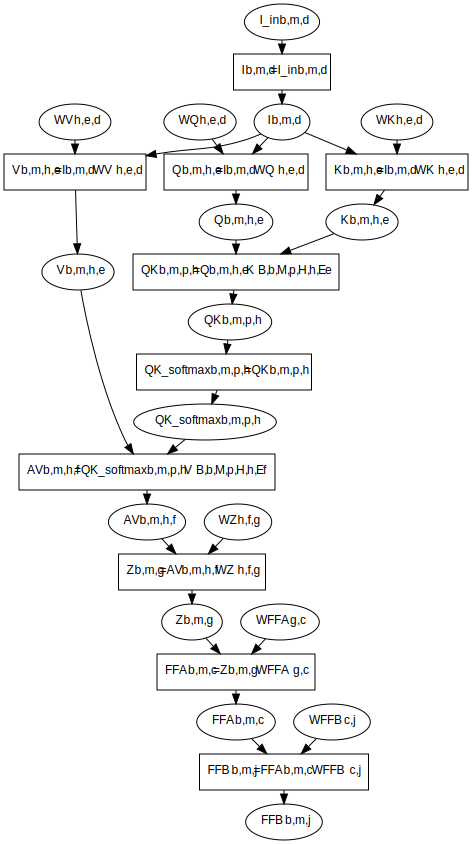

In [2]:
spec.workload

Next, we'll set optimization metrics for the mapper. Note that having more metrics will
make the mapper slower because it is more difficult to prune suboptimal mappings,
because it must prove that something is Pareto-dominated in all metrics.

In [3]:
# Set optimization metrics
spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.ENERGY
# spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.LATENCY
# spec.mapper.ffm.metrics = ff.mapper.FFM.Metrics.LATENCY | ff.mapper.FFM.Metrics.ENERGY

<!-- < DOC_INCLUDE_MARKER > FFM_parts -->

The mapper consists of two parts:

- The Turbo-Charged Pmapper: This part makes all Pareto-optimal pmappings for all
  Einsums.
- Fast and Fusiest: This part takes the Pareto-optimal pmappings and joins them into
  full mappings.

Mapping begins with the Turbo-Charged Pmapper with the `make_pmappings` function.

In [4]:
# < DOC_INCLUDE_MARKER > make_pmappings

# Commenting this will be slower, but may generate better mappings. Limits the number of
# fused loops that can exist in a single pmapping.
spec.mapper.ffm.max_fused_loops = 1

pmappings = ff.mapper.FFM.make_pmappings(
    spec,
    # Having can_combine_multiple_runs=False is faster, so it should generally be set to
    # True. If it is set to False, then you may run make_pmappings multiple times with
    # compatible specs and combine them:
    #   pmappings = make_pmappings(*args_a) | make_pmappings(*args_b)
    can_combine_multiple_runs=False
)

Generating jobs:   0%|          | 0/20 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s]s] ?it/s] ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum I: 1it [00:00, 12.17it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s] 29.93it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK_softmax: 6it [00:00, 49.96it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Ei

NameError: name 'util' is not defined

In [5]:
# < DOC_INCLUDE_MARKER > pmappings_stats

# Output some stats about the generated pmappings.
print(f"Total number of pmappings: {pmappings.n_total_pmappings()}")
print(f"Number of valid pmappings: {pmappings.n_valid_pmappings()}")
print(f"Number of Pareto-optimal pmappings: {pmappings.n_pareto_optimal_pmappings()}")
print(f"Number of evaluated pmappings: {pmappings.n_evaluated_pmappings()}")

Total number of pmappings: 435283622695
Number of valid pmappings: 709929014.7193956
Number of Pareto-optimal pmappings: 10
Number of evaluated pmappings: 808823


In [6]:
# < DOC_INCLUDE_MARKER > join_pmappings

# Join the pmappings to create a full mapping.
mappings = ff.mapper.FFM.join_pmappings(spec,pmappings)

Einsum I has 1 pmappings with 1 compatibilities
Einsum V has 1 pmappings with 1 compatibilities
Einsum K has 1 pmappings with 1 compatibilities
Einsum Q has 1 pmappings with 1 compatibilities
Einsum QK has 1 pmappings with 1 compatibilities
Einsum QK_softmax has 1 pmappings with 1 compatibilities
Einsum AV has 1 pmappings with 1 compatibilities
Einsum Z has 1 pmappings with 1 compatibilities
Einsum FFA has 1 pmappings with 1 compatibilities
Einsum FFB has 1 pmappings with 1 compatibilities


Compressing pmappings: 100%|██████████| 10/10 [00:00<00:00, 425.03it/s]


Not tracking ArrayDummy because it is never reserved for multiple pmappings.
Not tracking GlobalBuffer because it is never reserved for multiple pmappings.
Not tracking LocalBuffer because it is never reserved for multiple pmappings.
Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 8559.80it/s]


In [7]:
# The joined pmappings object contains a DataFrame of all Pareto-optimal pmappings for
# the given optimization metrics. Since we're only interested in one metric, this should
# have exaclty one row, but we'll grab index 0 to be sure.
mapping = mappings[0]

# All units are SI units-- seconds, joules, meters, etc.
print(f"Totals:")

# The access method accesses all columns that include Total.
for k, v in mapping.access("Total").to_dict().items():
    print(f"\t{k}: {v}")

Totals:
	energy: 68722.42349735575
	mapping: <fastfusion.mapper.FFM.main.MappingFromRow object at 0x7f789329ee70>


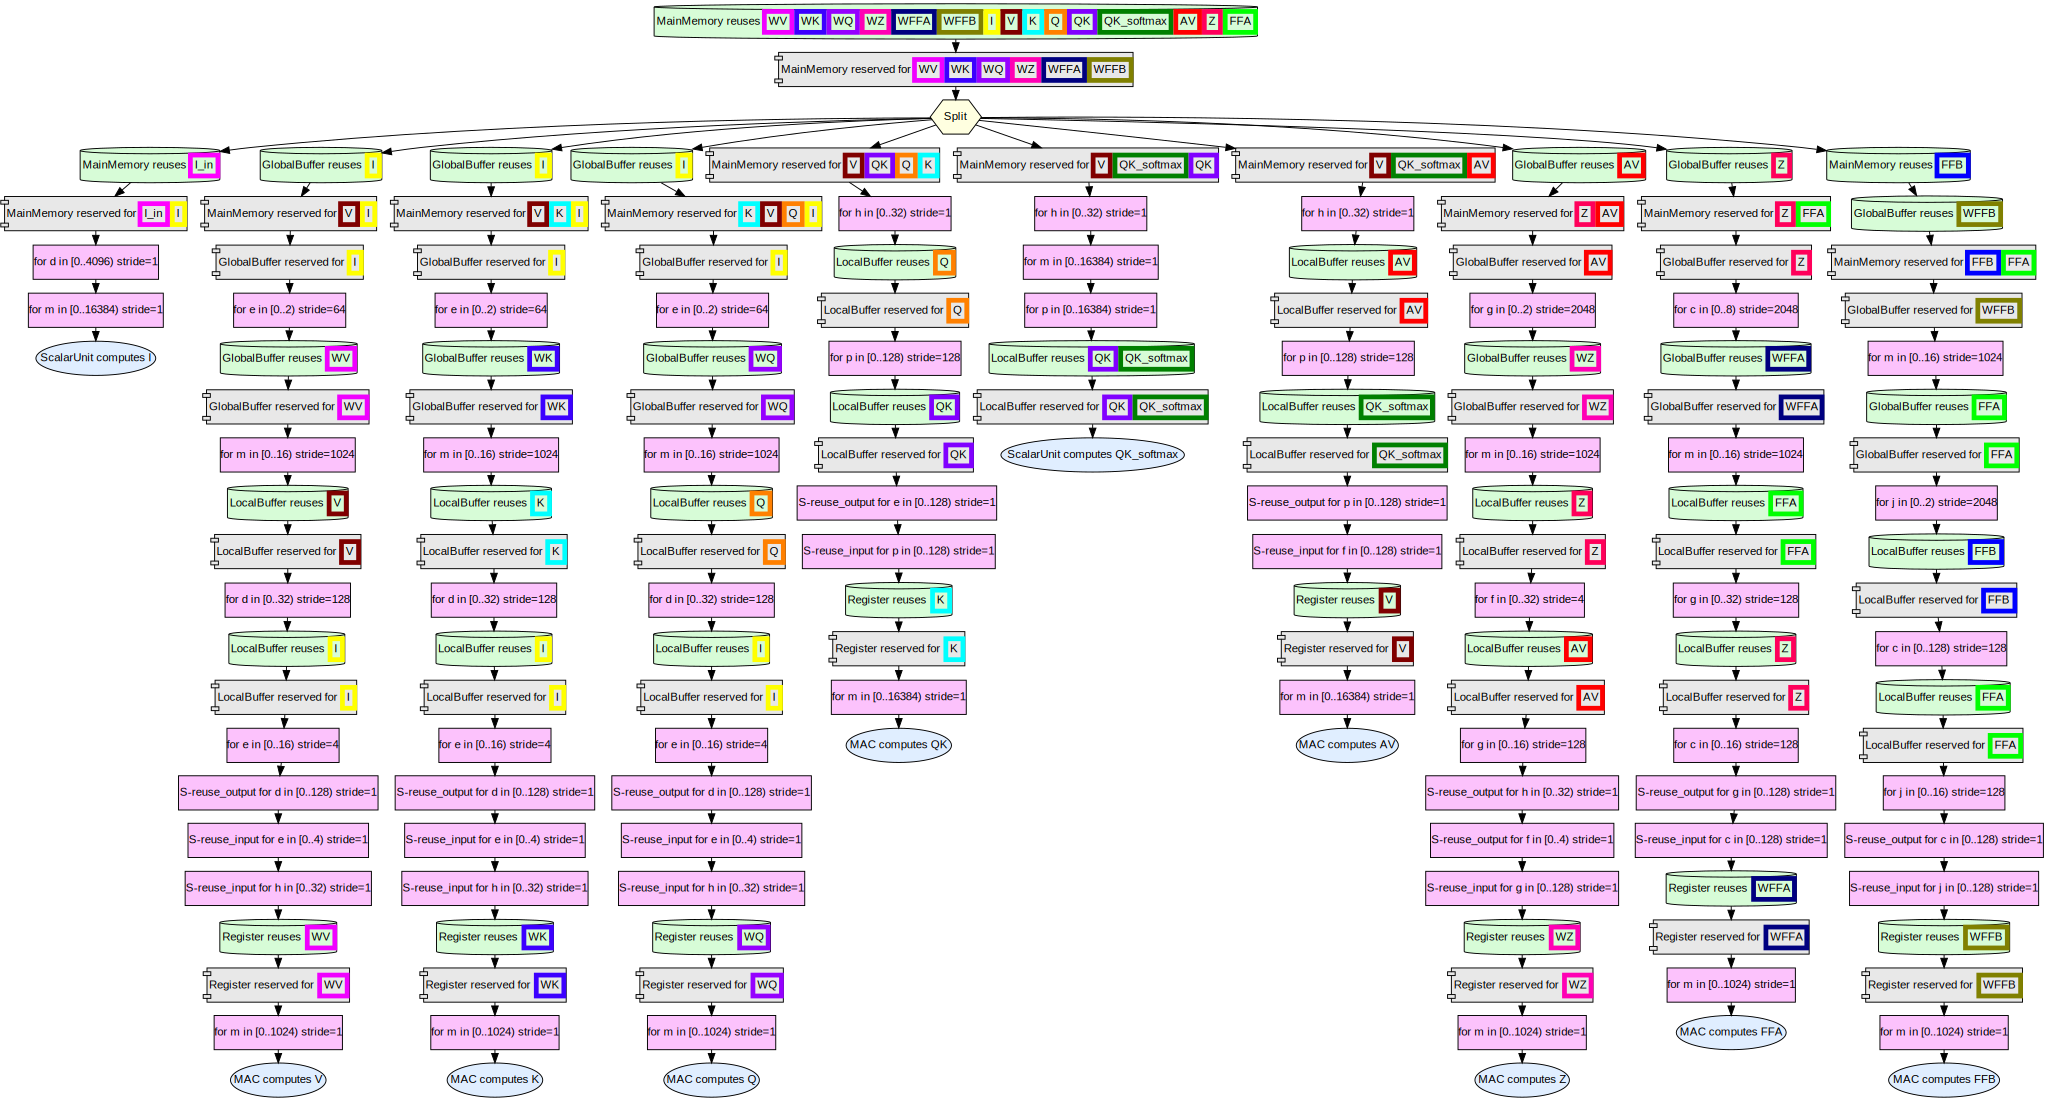

In [ ]:
# Show the mapping.
mapping

In [ ]:
accessor = "latency" if spec.mapper.ffm.metrics == ff.mapper.FFM.Metrics.LATENCY else "energy"
per_compute = mapping.access("Total").per_compute().to_dict()[accessor]
print(f'Per-compute {accessor}: {per_compute}')

print(f'Contributors to {accessor}:')
for k, v in mapping.access(accessor).to_dict().items():
    print(f"\t{k}: {v}")

# Print the other stats
for k, v in mapping.to_dict().items():
    print(f"{k}: {v}")

Per-compute energy: 1.2480882279686064e-08
Contributors to energy:
	Total: 68722.42349735575
	I<SEP>MainMemory<SEP>leak: 0
	I<SEP>GlobalBuffer<SEP>leak: 0
	I<SEP>LocalBuffer<SEP>leak: 0
	I<SEP>ScalarUnit<SEP>leak: 0
	I<SEP>ArrayDummy<SEP>leak: 0
	I<SEP>Register<SEP>leak: 0
	I<SEP>MAC<SEP>leak: 0
	V<SEP>Register<SEP>read: 0
	V<SEP>Register<SEP>write: 0
	V<SEP>LocalBuffer<SEP>read: 0.008555575273931026
	V<SEP>LocalBuffer<SEP>write: 0.005348308011889458
	V<SEP>GlobalBuffer<SEP>read: 0.00605590408667922
	V<SEP>GlobalBuffer<SEP>write: 0.0015837692189961672
	V<SEP>MainMemory<SEP>read: 0.004717753268778324
	V<SEP>MainMemory<SEP>write: 0.0037742024287581444
	V<SEP>MAC<SEP>compute: 0.023089744183296
	V<SEP>MainMemory<SEP>leak: 0
	V<SEP>GlobalBuffer<SEP>leak: 0
	V<SEP>LocalBuffer<SEP>leak: 0
	V<SEP>ScalarUnit<SEP>leak: 0
	V<SEP>ArrayDummy<SEP>leak: 0
	V<SEP>Register<SEP>leak: 0
	V<SEP>MAC<SEP>leak: 0
	K<SEP>Register<SEP>read: 0
	K<SEP>Register<SEP>write: 0
	K<SEP>LocalBuffer<SEP>read: 0.00855557